| using device: cuda


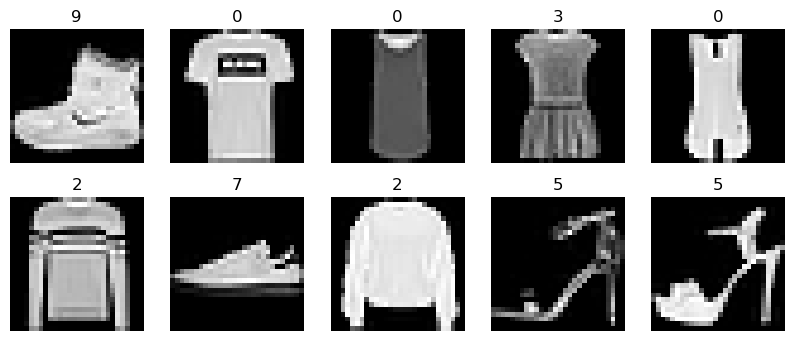

60000
0
iid:  tensor([65., 56., 62., 65., 64., 59., 49., 44., 63., 73.])


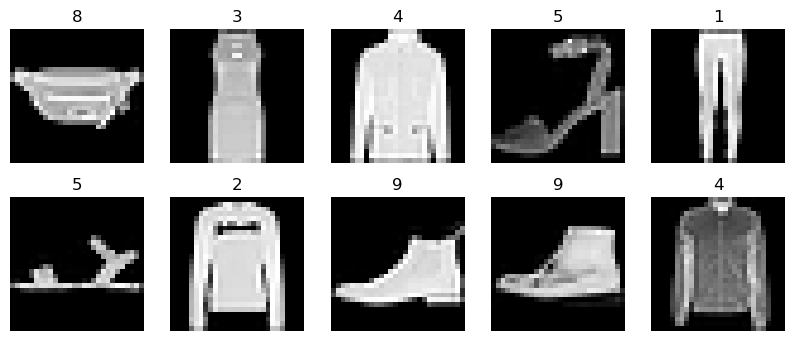

non-iid:  tensor([  0.,   0.,   0.,   0.,   0., 250., 250.,   0.,   0.,   0.])


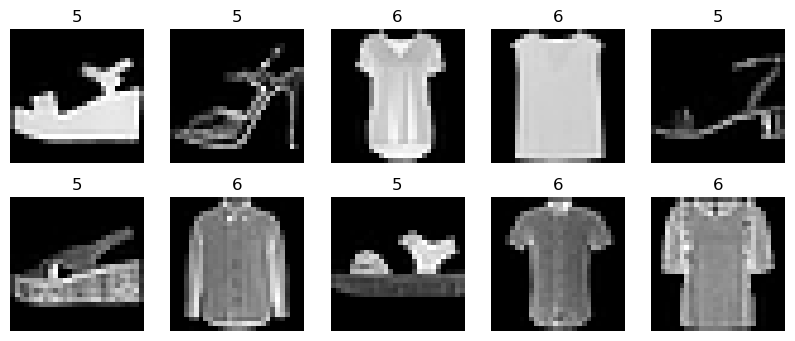

In [1]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)
# hyperparams
bsz = 10
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
train_data, test_data = fetch_dataset()

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)

noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)
from util import num_params
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # [B x 784]
        x = F.relu(self.fc1(x)) # [B x 200]
        x = F.relu(self.fc2(x)) # [B x 200]
        x = self.out(x) # [B x 10]
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128*4*4, 128) # [64*4*4, 64*5*5]
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = F.max_pool2d(self.conv3(x), 2, 2)
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x
criterion = nn.CrossEntropyLoss()


def validate(model):
	model = model.to("cuda")
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for (t, (x, y)) in enumerate(test_loader):
			x = x.to("cuda")
			y = y.to("cuda")
			out = model(x)
			correct += torch.sum(torch.argmax(out, dim=1) == y).item()
			total += x.shape[0]
	return correct / total


def train_client(id, client_loader, global_model, num_local_epochs, lr):
	local_model = copy.deepcopy(global_model)
	local_model = local_model.to("cuda")
	local_model.train()
	optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

	for epoch in range(num_local_epochs):
		for (i, (x, y)) in enumerate(client_loader):
			x = x.to("cuda")
			y = y.to("cuda")
			optimizer.zero_grad()
			out = local_model(x)
			loss = criterion(out, y)
			loss.backward()
			optimizer.step()

	return local_model


def running_model_avg(current, next, scale):
	if current == None:
		current = next
		for key in current:
			current[key] = current[key] * scale
	else:
		for key in current:
			current[key] = current[key] + (next[key] * scale)
	return current


def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds,
                       filename):
	round_accuracy = []
	for t in range(max_rounds):
		print("starting round {}".format(t))

		# choose clients
		clients = np.random.choice(np.arange(100), num_clients_per_round, replace=False)
		print("clients: ", clients)

		global_model.eval()
		global_model = global_model.to("cpu")
		running_avg = None

		for i, c in enumerate(clients):
			# train local client
			print("round {}, starting client {}/{}, id: {}".format(t, i + 1, num_clients_per_round, c))
			local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

			# add local model parameters to running average
			running_avg = running_model_avg(running_avg, local_model.state_dict(), 1 / num_clients_per_round)

		# set global model parameters for the next step
		global_model.load_state_dict(running_avg)

		# validate
		val_acc = validate(global_model)
		print("round {}, validation acc: {}".format(t, val_acc))
		round_accuracy.append(val_acc)

		if (t % 10 == 0):
			np.save(filename + '_{}'.format(t) + '.npy', np.array(round_accuracy))

	return np.array(round_accuracy)

In [2]:
mlp = MLP()
print(mlp)
print("total params: ", num_params(mlp))

cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
total params:  199210
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
total params:  582026


In [3]:
# MLP - iid - m=10 experiment
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_avg_experiment(mlp_iid_m10, num_clients_per_round=50,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m10')

print(acc_mlp_iid_m10)
np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)
print("1")
# MLP - iid - m=10 experiment
mlp_iid_m11 = copy.deepcopy(mlp)
acc_mlp_iid_m11 = fed_avg_experiment(mlp_iid_m11, num_clients_per_round=50,
                                 num_local_epochs=1,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m11')

print(acc_mlp_iid_m11)
np.save('./acc_mlp_iid_m11.npy', acc_mlp_iid_m11)
print("2")
# MLP - iid - m=10 experiment
mlp_iid_m12 = copy.deepcopy(mlp)
acc_mlp_iid_m12 = fed_avg_experiment(mlp_iid_m12, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m12')

print(acc_mlp_iid_m12)
np.save('./acc_mlp_iid_m12.npy', acc_mlp_iid_m12)
print("3")
# MLP - iid - m=10 experiment
mlp_iid_m13 = copy.deepcopy(mlp)
acc_mlp_iid_m13 = fed_avg_experiment(mlp_iid_m13, num_clients_per_round=50,
                                 num_local_epochs=10,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m13')

print(acc_mlp_iid_m13)
np.save('./acc_mlp_iid_m13.npy', acc_mlp_iid_m13)
print("4")

# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m10')
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)
print("5")
# CNN - iid - m=10 experiment
cnn_iid_m11 = copy.deepcopy(cnn)
acc_cnn_iid_m11 = fed_avg_experiment(cnn_iid_m11, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.005,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m11')
print(acc_cnn_iid_m11)
np.save('./acc_cnn_iid_m11.npy', acc_cnn_iid_m11)
print("6")
# CNN - iid - m=10 experiment
cnn_iid_m12 = copy.deepcopy(cnn)
acc_cnn_iid_m12 = fed_avg_experiment(cnn_iid_m12, num_clients_per_round=50,
                                 num_local_epochs=10,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m12')
print(acc_cnn_iid_m12)
np.save('./acc_cnn_iid_m12.npy', acc_cnn_iid_m12)
print("7")
# CNN - iid - m=10 experiment
cnn_iid_m13 = copy.deepcopy(cnn)
acc_cnn_iid_m13 = fed_avg_experiment(cnn_iid_m13, num_clients_per_round=50,
                                 num_local_epochs=10,
                                 lr=0.005,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m13')
print(acc_cnn_iid_m13)
np.save('./acc_cnn_iid_m13.npy', acc_cnn_iid_m13)
print("Done")

starting round 0
clients:  [26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76 60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40
 38  5]
round 0, starting client 1/50, id: 26
round 0, starting client 2/50, id: 86
round 0, starting client 3/50, id: 2
round 0, starting client 4/50, id: 55
round 0, starting client 5/50, id: 75
round 0, starting client 6/50, id: 93
round 0, starting client 7/50, id: 16
round 0, starting client 8/50, id: 73
round 0, starting client 9/50, id: 54
round 0, starting client 10/50, id: 95
round 0, starting client 11/50, id: 53
round 0, starting client 12/50, id: 92
round 0, starting client 13/50, id: 78
round 0, starting client 14/50, id: 13
round 0, starting client 15/50, id: 7
round 0, starting client 16/50, id: 30
round 0, starting client 17/50, id: 22
round 0, starting client 18/50, id: 24
round 0, starting client 19/50, id: 33
round 0, starting client 20/50, id: 8
round 0, starting client 21/50, id: 43
round 0, sta

In [4]:
# MLP - iid - m=10 experiment
mlp_noniid_m10 = copy.deepcopy(mlp)
acc_mlp_noniid_m10 = fed_avg_experiment(mlp_noniid_m10, num_clients_per_round=50,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m10')

print(acc_mlp_noniid_m10)
np.save('./acc_mlp_noniid_m10.npy', acc_mlp_noniid_m10)

# MLP - iid - m=10 experiment
mlp_noniid_m11 = copy.deepcopy(mlp)
acc_mlp_noniid_m11 = fed_avg_experiment(mlp_noniid_m11, num_clients_per_round=50,
                                 num_local_epochs=1,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m11')

print(acc_mlp_noniid_m11)
np.save('./acc_mlp_noniid_m11.npy', acc_mlp_noniid_m11)

# MLP - iid - m=10 experiment
mlp_noniid_m12 = copy.deepcopy(mlp)
acc_mlp_noniid_m12 = fed_avg_experiment(mlp_noniid_m12, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m12')

print(acc_mlp_noniid_m12)
np.save('./acc_mlp_noniid_m12.npy', acc_mlp_noniid_m12)

# MLP - iid - m=10 experiment
mlp_noniid_m13 = copy.deepcopy(mlp)
acc_mlp_noniid_m13 = fed_avg_experiment(mlp_noniid_m13, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m13')

print(acc_mlp_noniid_m13)
np.save('./acc_mlp_noniid_m13.npy', acc_mlp_noniid_m13)


# CNN - iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

# CNN - iid - m=10 experiment
cnn_noniid_m11 = copy.deepcopy(cnn)
acc_cnn_noniid_m11 = fed_avg_experiment(cnn_noniid_m11, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.005,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_noniid_m11')
print(acc_cnn_noniid_m11)
np.save('./acc_cnn_noniid_m11.npy', acc_cnn_noniid_m11)

# CNN - iid - m=10 experiment
cnn_noniid_m12 = copy.deepcopy(cnn)
acc_cnn_noniid_m12 = fed_avg_experiment(cnn_noniid_m12, num_clients_per_round=50,
                                 num_local_epochs=10,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_noniid_m12')
print(acc_cnn_noniid_m12)
np.save('./acc_cnn_noniid_m12.npy', acc_cnn_noniid_m12)

# CNN - iid - m=10 experiment
cnn_noniid_m13 = copy.deepcopy(cnn)
acc_cnn_noniid_m13 = fed_avg_experiment(cnn_noniid_m13, num_clients_per_round=50,
                                 num_local_epochs=10,
                                 lr=0.005,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_noniid_m13')
print(acc_cnn_noniid_m13)
np.save('./acc_cnn_noniid_m13.npy', acc_cnn_noniid_m13)

starting round 0
clients:  [55 14 64 50  3 87 41 89 78 80 70 67 35 11 75 96 47 26 52 74 68 62 69 77
 54  5 91 82 17 58 92 36 40 59 94 90 57 53 73 20 51 33  0 93 32 37 30 18
 31 95]
round 0, starting client 1/50, id: 55
round 0, starting client 2/50, id: 14
round 0, starting client 3/50, id: 64
round 0, starting client 4/50, id: 50
round 0, starting client 5/50, id: 3
round 0, starting client 6/50, id: 87
round 0, starting client 7/50, id: 41
round 0, starting client 8/50, id: 89
round 0, starting client 9/50, id: 78
round 0, starting client 10/50, id: 80
round 0, starting client 11/50, id: 70
round 0, starting client 12/50, id: 67
round 0, starting client 13/50, id: 35
round 0, starting client 14/50, id: 11
round 0, starting client 15/50, id: 75
round 0, starting client 16/50, id: 96
round 0, starting client 17/50, id: 47
round 0, starting client 18/50, id: 26
round 0, starting client 19/50, id: 52
round 0, starting client 20/50, id: 74
round 0, starting client 21/50, id: 68
round 0, s